In [1]:
import os, sys
import h5py, glob
import numpy as np
from tqdm.auto import trange

from provabgs import util as UT
from provabgs import infer as Infer
from provabgs import models as Models

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from astropy.table import Table
from astropy.cosmology import Planck13

In [3]:
bgs = Table.read('/global/cfs/cdirs/desicollab/science/gqp/stellar_mass_comparison/bgs-test.fits')

In [4]:
logmstar_bf = np.repeat(-999., len(bgs))
logmstar = np.tile(-999, (len(bgs), 100))

In [5]:
m_nmf = Models.NMF(burst=True, emulator=True)

input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [6]:
dat_dir = '/global/cscratch1/sd/chahah/provabgs/challenge/stellar_mass/'
for igal in trange(len(bgs)): 
    
    fname = os.path.join(dat_dir, f'bgs_test.{igal}.hdf5')
    if not os.path.isfile(fname): continue 

    with h5py.File(fname, 'r') as fhpix:
        if 'redshift' not in fhpix.keys():
            print()
            print('gal %i is problematic' % hpix)
            print()
            continue
        zreds = fhpix['redshift'][...]
        
        # get posterior samples and log probabilities
        _logp = fhpix['log_prob'][...][-1000:].flatten()
        _theta = fhpix['mcmc_chain'][...][-1000:]
        _theta = _theta.reshape((_theta.shape[0] * _theta.shape[1], _theta.shape[2]))

        # get best-fit theta
        theta_bfs = _theta[np.argmax(_logp)]
        
    # calculate M* (surviving stellar mass)
    tage = Planck13.age(zreds).value
    logmstar_bf[igal] = np.log10(m_nmf._surviving_mass(theta_bfs[:12], tage))
    logmstar[igal,:] = np.random.choice(np.log10(m_nmf._surviving_mass(_theta[:,:-1], tage)), size=100, replace=False)
    
    #print(22.5 - 2.5 * np.log10(bgs['FLUX_R'])[igal], bgs['Z'][igal], theta_bfs[0], logmstar_bf[igal])

100%|██████████| 50578/50578 [2:56:11<00:00,  4.78it/s]   


In [7]:
print(np.sum(logmstar_bf != -999.))

46360


In [8]:
import matplotlib.pyplot as plt


Bad key text.latex.preview in file /global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95 

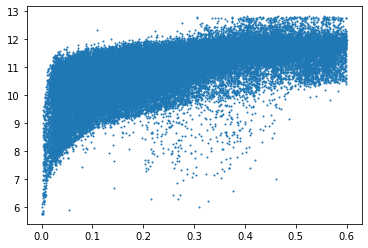

In [9]:
plt.scatter(bgs['Z'][logmstar_bf != -999.], logmstar_bf[logmstar_bf != -999.], s=1)

In [10]:
tab = Table()

In [11]:
for k in ['TARGETID', 'SURVEY', 'PROGRAM', 'HEALPIX', 'Z']: 
    tab[k] = bgs[k]

In [12]:
tab['logmstar_bf'] = logmstar_bf
tab['logmstar'] = logmstar

In [13]:
tab.write('/global/cscratch1/sd/chahah/provabgs/challenge/bgs-test.logmstar.desi_cosmo.fits')